# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
%matplotlib inline
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 允许重复加载 OpenMP



# b. MNIST Data Loader

In [4]:
def binarize_image(tensor):
    return (tensor > 0.5).float()

tensor_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(binarize_image)
])

batch_size = 128
train_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)
test_dataset = datasets.MNIST(root = "./data",
									train = False,
									download = True,
									transform = tensor_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
							   batch_size = batch_size,
								 shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
							   batch_size = batch_size,
								 shuffle = False)


# **1. PixelCNN**


# a. Training Function

In [5]:
bce = F.binary_cross_entropy

def train(dataloader, model, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            tgt = images.clone()
            pred = model(images)
            # loss = bce(pred, tgt)
            tgt = tgt.squeeze(1).long()
            loss = F.cross_entropy(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# b. Masked Convolution

In [6]:
class MaskedConv2d(nn.Conv2d):
    ##################
    ### Problem 2(a): Implement MaskedConv2d
    def __init__(self, mask_type, **kwargs):
        super().__init__(**kwargs)
        mask = torch.zeros_like(self.weight)
        h, w = self.kernel_size
        center_h, center_w = h // 2, w // 2
        if mask_type == 'A':
            mask[:, :, :center_h, :] = 1
            mask[:, :, center_h, :center_w] = 1
        elif mask_type == 'B':
            mask[:, :, :center_h, :] = 1
            mask[:, :, center_h, :center_w+1] = 1
        
        self.register_buffer('mask', mask)
    def forward(self, x):
        # self.weight.data *= self.mask
        # return super().forward(x)
        masked_weight = self.weight * self.mask # 创建一个被掩码的权重副本
        return F.conv2d(x, masked_weight, self.bias, self.stride, self.padding, self.dilation, self.groups)
    ##################


# c. Model

In [7]:
class PixelCNN(nn.Module):
    ##################
    ### Problem 2(b): Implement PixelCNN
    def __init__(self):
        super().__init__()
        Type_A = MaskedConv2d(mask_type='A', in_channels = 1, out_channels = 32, kernel_size = 7, padding = 3, )
        Type_B =MaskedConv2d(mask_type='B', in_channels = 32, out_channels = 32, kernel_size = 3, padding = 1, )
        layers = []
        layers.append(Type_A)
        for _ in range(2):
            layers.append(torch.nn.ReLU())
            layers.append(Type_B)
        self.main_layer = nn.Sequential(*layers)
        self.out_layer = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(32, 256, 1)
        )

    def forward(self, x):
        x = self.main_layer(x)
        x = self.out_layer(x)
        return x
    ##################

# d. Training

In [22]:
##################
### Problem 2(c): Training
epochs = 100
model = PixelCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train(train_loader, model, optimizer, epochs)
##################


Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [1/100], Average Loss: 0.5382



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [2/100], Average Loss: 0.1063



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [3/100], Average Loss: 0.1014



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [4/100], Average Loss: 0.0996



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [5/100], Average Loss: 0.0984



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [6/100], Average Loss: 0.0976



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [7/100], Average Loss: 0.0970



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [8/100], Average Loss: 0.0966



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [9/100], Average Loss: 0.0962



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [10/100], Average Loss: 0.0959



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [11/100], Average Loss: 0.0956



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

----
Epoch [12/100], Average Loss: 0.0954



Batches:   0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

# e. Evaluation (Reconstruction)

torch.Size([128, 1, 28, 28])


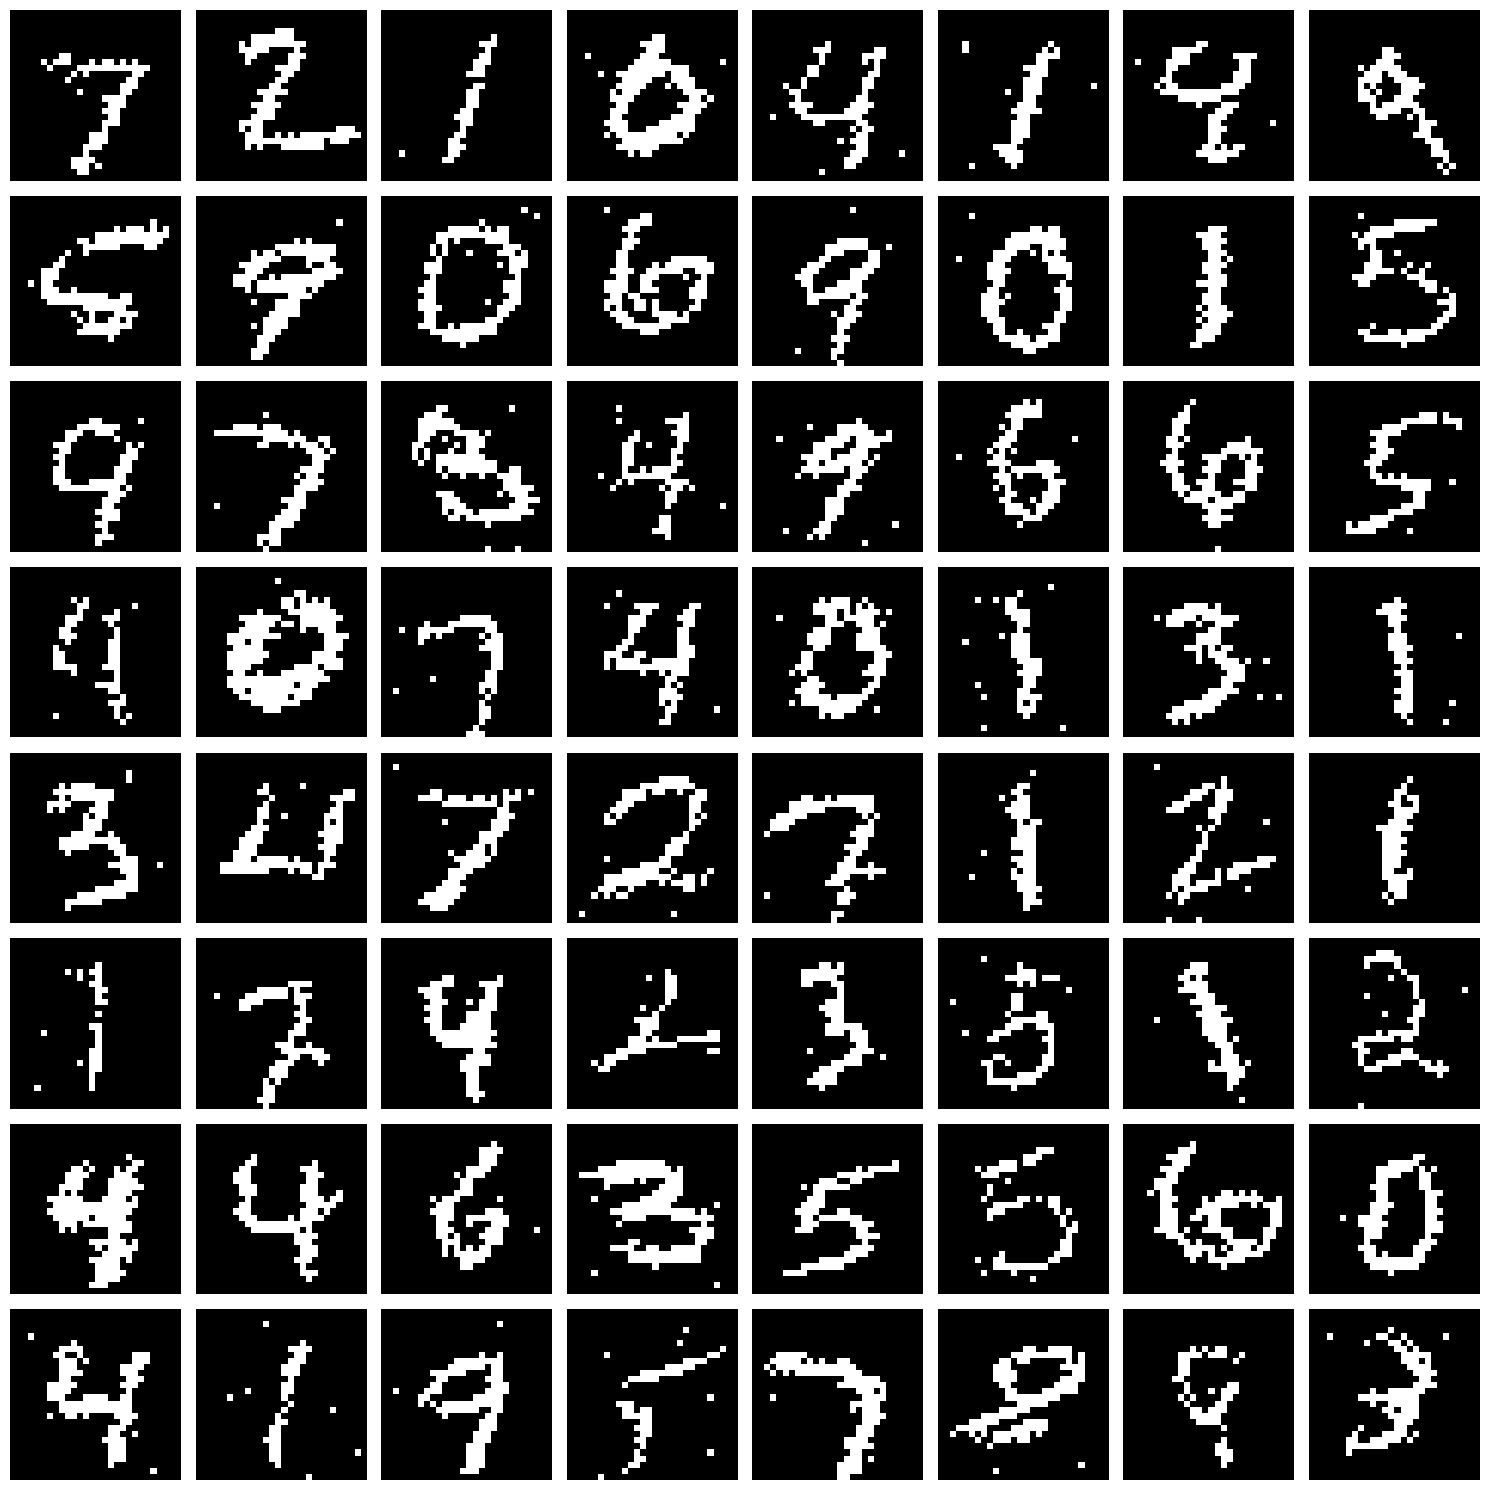

In [28]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      pred = model(images)
      pred = F.softmax(pred, dim=1)

      probs_flat = pred.permute(0, 2, 3, 1).reshape(-1, pred.shape[1])
      
      # 对每个扁平化的像素采样一个值
      sampled_pixels_flat = torch.multinomial(probs_flat, 1) # 形状 (B*H*W, 1)
      
      # 将采样结果重塑回 (batch_size, H, W)
      sampled_pixels = sampled_pixels_flat.reshape(batch_size, H, W)
      reconstructed_images = sampled_pixels.float().unsqueeze(1) 
      pred = reconstructed_images
      break
print(pred.shape)
samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
# print(samples.shape)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample.squeeze(), cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

开始生成图像样本...
torch.Size([64, 1, 28, 28])


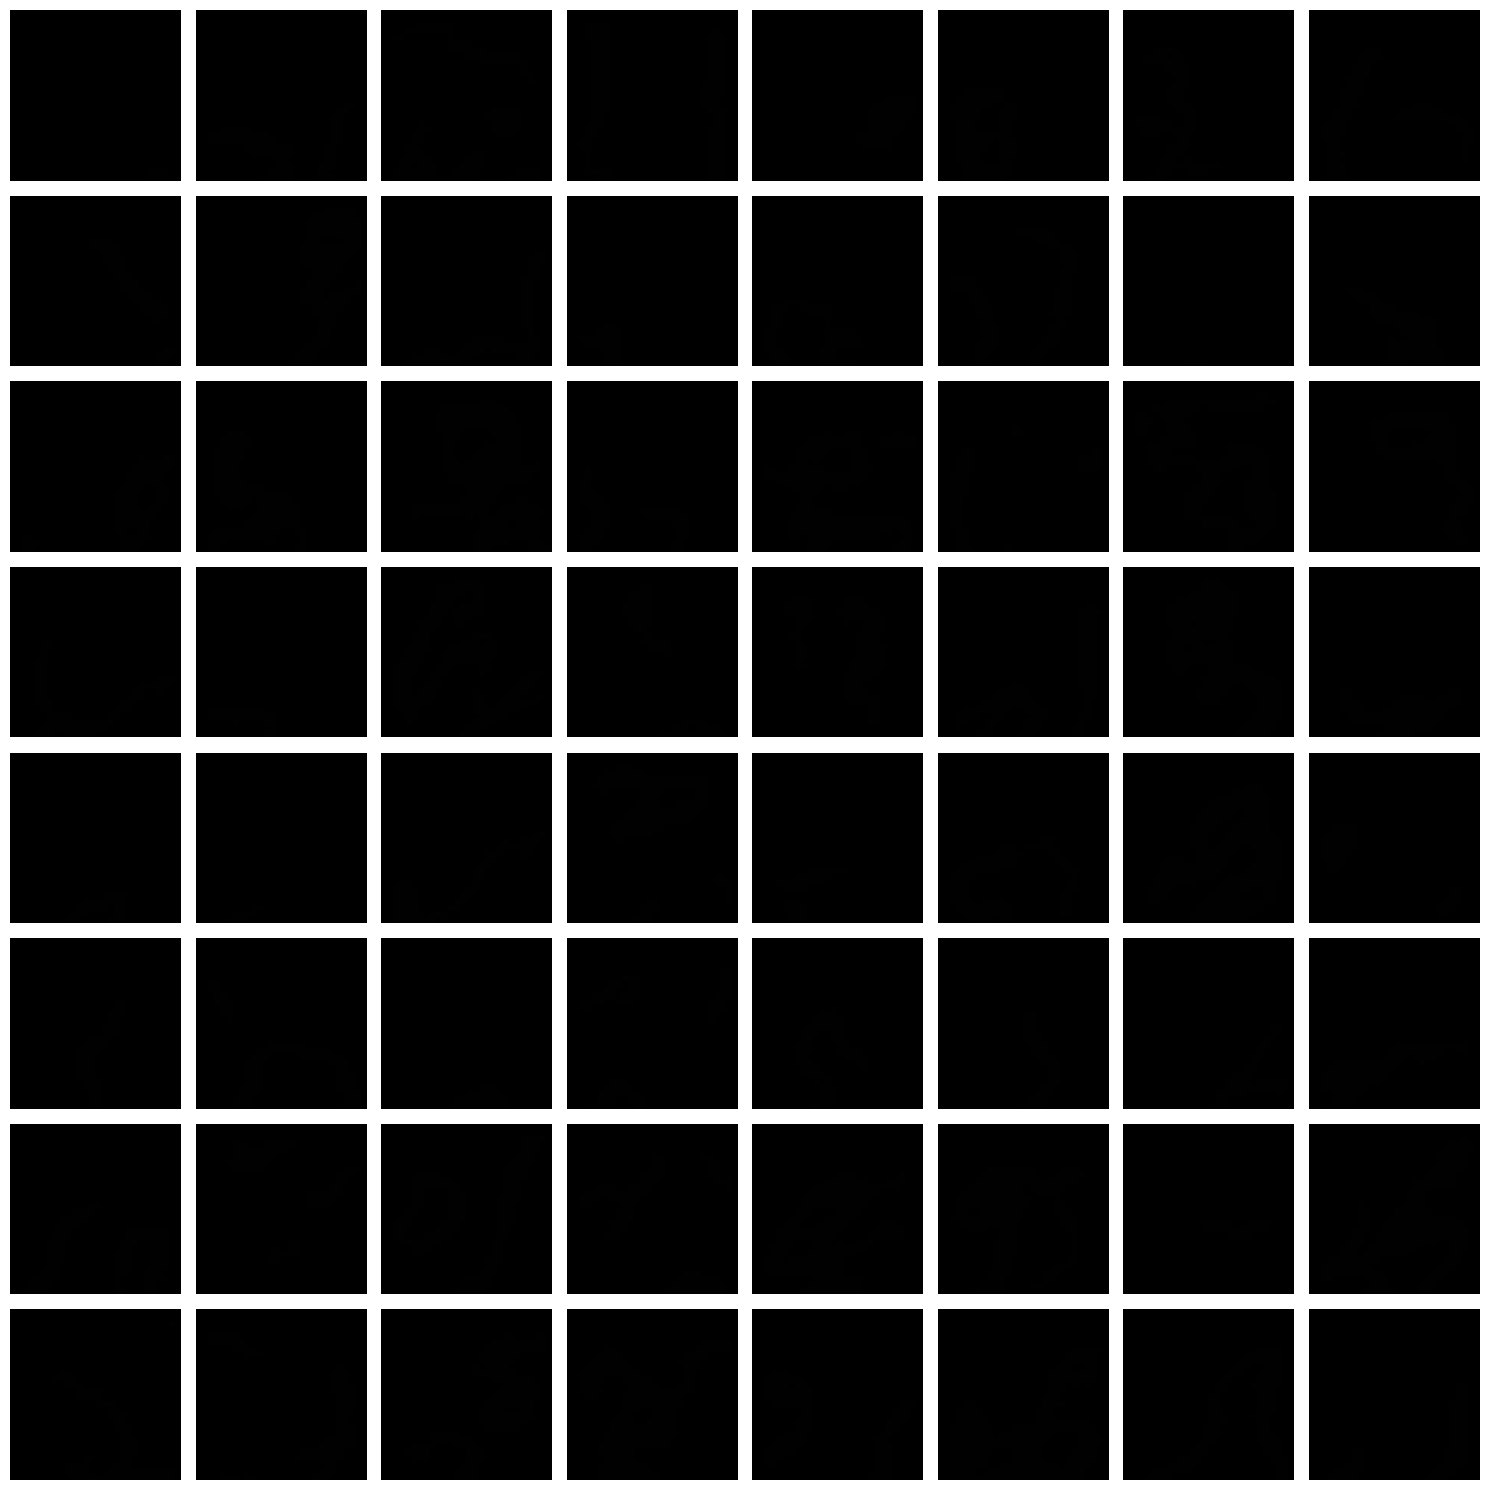

In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 假设你的 PixelCNN 模型和 MaskedConv2d 已经定义并训练好了
# 并且模型已经加载到 device 上
# model.eval() # 确保模型处于评估模式

H, W = 28, 28
num_samples = 64 # 要生成的图像数量
num_pixel_values = 256 # 像素值范围 0-255

# 创建一个用于存储生成图像的空白张量
# 注意：这里是 (batch_size, 1, H, W) 因为 MNIST 是单通道
generated_images = torch.zeros(num_samples, 1, H, W).to(device)

with torch.no_grad():
    for i in range(H): # 遍历行
        for j in range(W): # 遍历列
            logits = model(generated_images) 
            pixel_logits = logits[:, :, i, j] # 形状是 (num_samples, 256)
            probs = F.softmax(pixel_logits, dim=1) # dim=1 是类别维度
            sampled_pixel_values = torch.multinomial(probs, 1) # 形状 (num_samples, 1)
            generated_images[:, 0, i, j] = sampled_pixel_values.float().squeeze(1)

samples_np = generated_images.detach().cpu().numpy().transpose(0, 2, 3, 1) # (N, H, W, C)

fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for k in range(num_samples):
    sample = samples_np[k]
    row, col = divmod(k, 8)
    axes[row, col].imshow(sample.squeeze(), cmap='gray', vmin=0, vmax=255) # squeeze for (H, W) for imshow
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# **2. Conditional PixelCNN**


# a. Training Function

In [14]:
def train_cond(dataloader, model, optimizer, epochs, n_classes):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            images = images.to(device)
            labels = labels.to(device)
            tgt = images.clone()
            labels = F.one_hot(labels, num_classes=n_classes).float()
            pred = model(images, labels)
            loss = bce(pred, tgt)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            avg_loss = running_loss * batch_size / len(train_dataset)
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses

# b. Conditional Masked Convolution

In [15]:
class ConditionalMaskedConv2d(MaskedConv2d):
    ##################
    ### Problem 3(b): Implement ConditionalMaskedConv2d
    def __init__(self, **args):
        pass
    def forward(self, x, class_condition):
        pass
    ##################

# c. Model

In [16]:
class ConditionalPixelCNN(nn.Module):
    ##################
    ### Problem 3(b): Implement ConditionalPixelCNN
    def __init__(self, num_classes):
        pass
    def forward(self, x, class_condition):
        pass
    ##################

# d. Training

In [17]:
##################
epochs = 100
### Problem 3(c): Training
n_classes = 10
model = ConditionalPixelCNN(n_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

log = train_cond(train_loader, model, optimizer, epochs, n_classes)
##################


AttributeError: 'ConditionalPixelCNN' object has no attribute '_modules'

# e. Evaluation (Reconstruction)

In [ ]:
H, W = 28, 28

with torch.no_grad():
  for iter, (images, labels) in enumerate(test_loader):
      images = images.to(device)
      labels = labels.to(device)
      labels = F.one_hot(labels, num_classes=n_classes).float()
      pred = model(images, labels)

      for i in range(H):
          for j in range(W):
              pred[:, :, i, j] = torch.bernoulli(pred[:, :, i, j], out=pred[:, :, i, j])
      break

samples = pred.detach().cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(8, 8, figsize=(15, 15))

for i in range(64):
    sample = samples[i]
    row, col = divmod(i, 8)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# f. Evaluation (Generation)

In [ ]:
samples = torch.zeros(size=(60, 1, H, W)).to(device)
sample_classes = np.sort(np.array([np.arange(n_classes)] * 6).flatten())
sample_classes = F.one_hot(torch.tensor(sample_classes), num_classes=n_classes).to(device).float()

with torch.no_grad():
    for i in range(H):
        for j in range(W):
            if j > 0 and i > 0:
                out = model(samples, sample_classes)
                samples[:, :, i, j] = torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = samples.cpu().numpy().transpose(0, 2, 3, 1)
fig, axes = plt.subplots(10, 6, figsize=(15, 30))

for i in range(60):
    sample = samples[i]
    row, col = divmod(i, 6)
    axes[row, col].imshow(sample, cmap='gray')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()